# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

### Check IP request ip setting from mobile udp client (robot-side)

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()


CONNECT_CAM = False # True
ENABLE_DETECT = True
# DETECT_MARKER = True
CONNECT_INDY = False # True
CONNECT_MOBILE = False # True 
VISUALIZE = True

# Tool dimensions
TOOL_DIM = [0.32, 0.08]
TOOL_OFFSET = 0.05
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

ip_cur = "192.168.0.8"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

from utils.streaming import *
from utils.detection_util import *

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                MOBILE_IP)
robot_config = RobotConfig(1, RobotType.indy7, (INDY_BASE_OFFSET, (0,0,0)),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, CONNECT_INDY])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(-3, 7, -5, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, Gripper2Tool, PlacePlane, SweepFramer, WayFramer
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
                                  rpy=(0,np.pi/2*1,0))

# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
                   dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), color=(1, 0, 0, 0.5), display=True,
                   collision=False, fixed=True)
wayframer = pscene.create_binder(bname="wayframer", gname="wayframer", _type=WayFramer, 
                                 point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

indy = crob.robot_dict["indy1"]

if CONNECT_MOBILE:
    sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
    time.sleep(1)

Current PC IP: 192.168.0.8
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10
connection command:
kmb0: False
indy1: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


### 0.2 Wait task start queue

## 1. Bed cleaning

### 1.1 Detect bed

#### 1.1.1 Move to bed-seek pose 

In [2]:
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = [0,]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

* **[TODO] rotate until bed is detected**

In [3]:
if ENABLE_DETECT:
    attacth_to_server()

In [4]:
CAM_HOST = '192.168.0.40'
if CONNECT_CAM:
    # rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
else:
#     cam_intrins = [1280, 720, 899.05322265625,  899.21044921875, 654.8836669921875, 352.9295654296875]
#     d_scale = 0.0002500000118743628
    cam_intrins = [1280, 720, 909.957763671875,  909.90283203125, 638.3824462890625, 380.0085144042969]
    d_scale = 1 / 3999.999810010204
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
#     bed_color_path = EXP_IMG_DIR + '/bed.jpg'
#     bed_depth_path = EXP_IMG_DIR + '/bed.png'
#     bed_color_path = EXP_IMG_DIR + '/513.jpg'
#     bed_depth_path = EXP_IMG_DIR + '/top_table_0024.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)

# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

# If bed is not detected, then pass below detection part
test = np.empty((720,1280), dtype=bool)
test[:,:] = False

In [5]:
while np.array_equal(mask_out, test):
    if CONNECT_INDY:
        with indy:
            Qnow = indy.get_joint_pos()
            Qto = np.add(Qnow, [10,0,0,0,0,0])
            Qto[0] = (Qto[0]+np.pi/2)%np.pi-np.pi/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
    
    
    # Take a picture again after rotate
    time.sleep(1)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    
    # Read color, depth image file, keep 16bit information
    color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
    depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)
    
    # Output of inference(mask for detected table)
    mask_out = detect_from_server(color_img_read)

#### 1.1.2  detect bed and add to the scene

In [6]:
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: Compute FPFH feature with search radius 0.228.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: Compute FPFH feature with search radius 0.228.
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.942439e-01, inlier_rmse=7.231539e-02, and correspondence_set size of 19553
Access transformation to get result.
Transformation is:
[[ 0.9124591  -0.02224235  0.40856292 -1.09099242]
 [-0.18218445 -0.91616465  0.35700303 -0.43707941]
 [ 0.36637032 -0.40018448 -0.84001498  5.19068886]
 [ 0.          0.          0.          1.        ]]


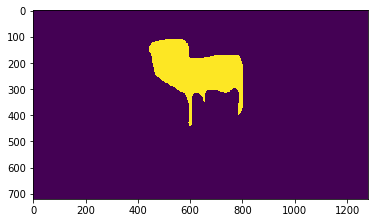

In [9]:
# Try ICP1
if not np.array_equal(mask_out, test):
    plt.imshow(mask_out)
    
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)
    
    ICP_result_bed1, fitness1 = process_bed_detection_front(T_bc, visualize=True)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: Compute FPFH feature with search radius 0.228.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: Compute FPFH feature with search radius 0.228.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.038,
   we use a liberal distance threshold 0.053.
[[ 0.851151    0.27685725  0.44597314 -1.29855469]
 [ 0.12875079 -0.93375746  0.33394648 -0.37764569]
 [ 0.50888625 -0.22681948 -0.83041418  5.06372764]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.965840e-01, inlier_rmse=7.230541e-02, and correspondence_set size of 19630
Access transformation to get result.
Transformation is:
[[ 0.90444971 -0.0177184   0.42621212 -1.1200565 ]
 [-0.18242457 -0.91923242  0.34890261 -0.41784005]
 [ 0.385606   -0.39331643

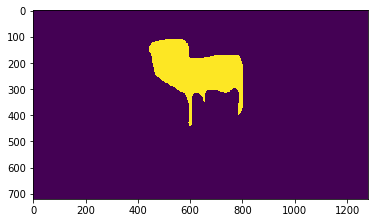

In [7]:
# Try ICP2
if not np.array_equal(mask_out, test):
    plt.imshow(mask_out)
    
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)
    
    ICP_result_bed2, fitness2 = process_bed_detection(visualize=True)

In [10]:
# Better result is adopted
if fitness1 > fitness2:
    ICP_result_bed = ICP_result_bed1
else:
    ICP_result_bed = ICP_result_bed2        

    
# Coorinate offeset
T_toff_bed = np.identity(4)
T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
T_toff_bed[:3,3] = np.array([0.455,0,1.02])

T_co_bed = np.matmul(ICP_result_bed, T_toff_bed)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
T_bo_bed = np.matmul(T_bc, T_co_bed)

bed_center = T_bo_bed[:3,3]
bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
# bed_center = (2,0,0)
# bed_rpy = (0,0,np.pi/2)
COLOR_BED_COL = (0,1,0,0.3)

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

In [11]:
bed_vis = gscene.NAME_DICT["bed_vis"]
# T_revis = np.identity(4)
# T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3))
# bed_rpy = Rot2rpy(Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3)
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi

move_bed(gscene, bed_center, bed_rpy)

#### 1.1.3  move to closet side

In [12]:
bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo_bed = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

In [13]:
if CONNECT_CAM:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
else:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
#     color_path = EXP_IMG_DIR + '/bed.jpg'
#     depth_path = EXP_IMG_DIR + '/bed.png'

# Determine the location of closet
CLOSET_LOCATION = check_location_top_table(color_path, depth_path, T_bc, T_bo_bed, bed_dims=bed_mat.dims, 
                                           visualize=False)
print("CLOSET on {}".format(CLOSET_LOCATION))

T_bm_from = wayframer.get_tf_handle(list2dict(VIEW_POSE_EXT, gscene.joint_names))
T_bs = bed_mat.get_tf(VIEW_POSE_EXT)

if CLOSET_LOCATION == "LEFT":
    T_sm = SE3(Rot_axis(3, np.pi), [1.5, -1.33, 0])
elif CLOSET_LOCATION == "RIGHT":       
    T_sm = SE3(Rot_axis(3, np.pi), [1.5, 1.33, 0])
    
T_bm = np.matmul(T_bs, T_sm)

x,y = T_bm[:2,3]
theta = Rot2axis(T_bm[:3,:3], 3)
VIEW_MOVED_EXT = np.add(VIEW_POSE_EXT, [x,y,theta]+[0]*9) 
gscene.show_pose(VIEW_MOVED_EXT)

CLOSET on LEFT


In [14]:
if CONNECT_MOBILE:
    VIEW_MOVED_EXT = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, VIEW_POSE_EXT, VIEW_MOVED_EXT, 
                                              D_APPROACH=0)
gscene.show_pose(VIEW_MOVED_EXT)

#### move camera up

In [15]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -70., 0])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    
VIEW_MOVED_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

In [16]:
if CONNECT_MOBILE:
    VIEW_MOVED_EXT = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, VIEW_POSE_EXT, VIEW_MOVED_EXT, 
                                              D_APPROACH=0)
gscene.show_pose(VIEW_MOVED_EXT)

#### 1.1.4  detect and add closet

In [17]:
bed_vis = gscene.NAME_DICT["bed_vis"]
if CONNECT_CAM:
    rdict = stream_capture_image(ImageType.FirstView, obj_type="closet", host=CAM_HOST)
    closet_color_path = SAVE_DIR + '/top_table.jpg'
    closet_depth_path = SAVE_DIR + '/top_table.png'
else:
    closet_color_path = SAVE_DIR + '/top_table.jpg'
    closet_depth_path = SAVE_DIR + '/top_table.png'
#     closet_color_path = EXP_IMG_DIR + '/top_table.jpg'
#     closet_depth_path = EXP_IMG_DIR + '/top_table.png'
    
if CONNECT_CAM:
    Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
else:
#     VIEW_POSE_MID = np.deg2rad([  0., -50.,  70.,  -0.,  75., -180])
#     VIEW_MOVED_EXT[6:] = VIEW_POSE_MID
    Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)

T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
T_sc = np.matmul(SE3_inv(T_bs), T_bc)

ICP_result_top_table = process_top_table_detection(closet_color_path, closet_depth_path, T_sc=T_sc,
                                                   bed_dims=bed_mat.dims, z_ceiling = 2.3,
                                                   initial_offset=[0.3,1.1,0.6], floor_margin=0.05,
                                                   visualize=True)

T_toff_top_table = np.identity(4)
T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

T_co_closet = np.matmul(ICP_result_top_table, T_toff_top_table)
T_bc = viewpoint.get_tf(list2dict(VIEW_MOVED_EXT, gscene.joint_names))
T_bo_closet = np.matmul(T_bc, T_co_closet)

# T_bo_closet[:3,:3] = Rot_axis(3, Rot2axis(T_bo_closet[:3,:3], 3))
T_bo_closet = align_z(T_bo_closet)
closet_center = T_bo_closet[:3,3]
closet_rpy=Rot2rpy(T_bo_closet[:3,:3])


                   
# adjust
closet_center[2]=0
if Rot_rpy(closet_rpy)[0,0] > 0:
    closet_rpy[2] += np.pi
# if Rot_rpy(closet_rpy)[1,0] < 0:
#     closet_rpy[2] -= np.pi/2

closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=closet_center, closet_rpy=closet_rpy, 
    COLOR_CLOSET_COL=(0,1,0,0.3))

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.394356e-01, inlier_rmse=1.992926e-02, and correspondence_set size of 1601
Access transformation to get result.
Transformation is:
[[-0.0617458  -0.03482087 -0.99748432  0.69270898]
 [ 0.02127863 -0.99921003  0.03356393  0.98606652]
 [-0.99786506 -0.01915267  0.06243797  2.49647147]
 [ 0.          0.          0.          1.        ]]


In [18]:
move_closet(gscene, closet_center=T_bo_closet[:3,3], closet_rpy=Rot2rpy(T_bo_closet[:3,:3]))

### 1.2 Make bed cleaning plan

#### 1.2.1 get division-base pose combination data

In [14]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

In [15]:
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

BED_OFFSET = 0.10
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

In [16]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(bed_mat, brush_face, robot_config, 
                                          plane_val=EE_HEIGHT, tip_dir=SweepDirections.front.name, TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02, 
                                          sweep_margin=0.0, xout_cut=True)

('Height Reference: ', 0.7020000109672546)


#### 1.2.2 select base poses and generate motions

In [ ]:
HOME_POSE_MOVE = VIEW_POSE
HOME_POSE_SWEEP = VIEW_MOVED_EXT
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    
test_fun = TestBaseDivFunc(ppline, floor_ws, bed_mat, WP_DIMS, TOOL_DIM, crob.home_dict)

test_fun.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step,
    test_fun=test_fun)

In [17]:
HOME_POSE_MOVE = VIEW_POSE
HOME_POSE_SWEEP = VIEW_MOVED_EXT
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    
test_fun = TestBaseDivFunc(ppline, floor_ws, bed_mat, WP_DIMS, TOOL_DIM, crob.home_dict)

test_fun.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step,
    test_fun=test_fun)

Use 36/36 agents
======================= terminated 13: max iteration time reached (1634040605/1634040602.85 s) ===============================
======================= terminated 33: max iteration time reached (1634040605/1634040602.85 s) ===============================
======================= terminated 5: max iteration time reached (1634040605/1634040602.85 s) ===============================
======================= terminated 14: max iteration time reached (1634040605/1634040602.85 s) ===============================
======================= terminated 19: max iteration time reached (1634040605/1634040602.85 s) ===============================
======================= terminated 26: max iteration time reached (1634040605/1634040602.85 s) ===============================
======================= terminated 8: max iteration time reached (1634040605/1634040602.85 s) ===============================
======================= terminated 28: max iteration time reached (1634040605/1634040602.85 s) =

======================= terminated 7: max iteration time reached (1634040606/1634040602.85 s) ===============================
======================= terminated 0: max iteration time reached (1634040606/1634040602.85 s) ===============================
======================= terminated 10: max iteration time reached (1634040606/1634040602.85 s) ===============================
======================= terminated 18: max iteration time reached (1634040606/1634040602.85 s) ===============================
======================= terminated 35: max iteration time reached (1634040606/1634040602.85 s) ===============================
======================= terminated 12: max iteration time reached (1634040606/1634040602.85 s) ===============================
======================= terminated 3: max iteration time reached (1634040606/1634040602.85 s) ===============================
======================= terminated 20: max iteration time reached (1634040606/1634040602.85 s) ===================

======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 30: first answer acquired from other agent ===============================
Goal reached
======================= terminated 8: first answer acquired ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 24: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
Goal reached
====

======================= terminated 2: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 13: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 12: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 1: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 22: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 35: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 16: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 4: max iteration time reached (1634040613/1634040610.21 s) ===================

======================= terminated 23: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 3: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 18: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 30: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 26: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 34: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 29: max iteration time reached (1634040613/1634040610.21 s) ===============================
======================= terminated 17: max iteration time reached (1634040613/1634040610.21 s) =================

======================= terminated 4: max iteration time reached (1634040617/1634040613.94 s) ===============================
======================= terminated 16: max iteration time reached (1634040617/1634040613.94 s) ===============================
======================= terminated 15: max iteration time reached (1634040617/1634040613.94 s) ===============================
======================= terminated 0: max iteration time reached (1634040617/1634040613.94 s) ===============================
======================= terminated 6: max iteration time reached (1634040617/1634040613.94 s) ===============================
======================= terminated 18: max iteration time reached (1634040617/1634040613.94 s) ===============================
======================= terminated 27: max iteration time reached (1634040617/1634040613.94 s) ===============================
======================= terminated 34: max iteration time reached (1634040617/1634040613.94 s) ===================

======================= terminated 35: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 15: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 9: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 25: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 24: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 23: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 11: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 27: max iteration time reached (1634040622/1634040619.07 s) =================

======================= terminated 16: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 32: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 3: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 8: max iteration time reached (1634040622/1634040619.07 s) ===============================
======================= terminated 5: max iteration time reached (1634040622/1634040619.07 s) ===============================
Use 36/36 agents
======================= terminated 3: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 1: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 34: max iteration time reached (1634040627/1634040624.17 s) ====

======================= terminated 22: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 30: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 6: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 14: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 19: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 4: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 17: max iteration time reached (1634040627/1634040624.17 s) ===============================
======================= terminated 11: max iteration time reached (1634040627/1634040624.17 s) ==================

======================= terminated 25: first answer acquired ===============================
======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired ===============================
======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 23: first answer acquired from other agent ===============================
Goal reached
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminate

Goal reached
======================= terminated 15: first answer acquired ===============================
Use 36/36 agents
Goal reached
======================= terminated 1: first answer acquired ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired from other agent ===============================
===

======================= terminated 19: first answer acquired ===============================
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 23: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired from other agent ===============================
Goal reached
======================= terminated 12: first answer acquired ===============================
Goal reached
======================= terminated 22: first answer acquired ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired from other agent ===============================
Goal reached
======================= terminated 0: first answer acquired ===============================
======================= terminated 24: firs

======================= terminated 6: max iteration time reached (1634040636/1634040633.13 s) ===============================
======================= terminated 29: max iteration time reached (1634040636/1634040633.13 s) ===============================
======================= terminated 9: max iteration time reached (1634040636/1634040633.13 s) ===============================
======================= terminated 2: max iteration time reached (1634040636/1634040633.13 s) ===============================
======================= terminated 19: max iteration time reached (1634040636/1634040633.13 s) ===============================
======================= terminated 8: max iteration time reached (1634040636/1634040633.13 s) ===============================
======================= terminated 24: max iteration time reached (1634040636/1634040633.13 s) ===============================
======================= terminated 20: max iteration time reached (1634040636/1634040633.13 s) ====================

Goal reached
======================= terminated 16: first answer acquired ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired ===============================
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated

======================= terminated 17: first answer acquired ===============================
======================= terminated 6: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 1: first answer acquired ===============================
======

======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================
Goal reached
======================= terminated 9: first answer acquired ===============================
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
Goal reached
======================= terminated 23: first answer acquired ===============================
Goal reached
======================= terminated 21: first answer acquired ===============================
Goal reached
======================= terminated 19: first answer acquired ===============================
Goal reached
======================= terminated 22: first answer acquired ===============================
======================= terminat

======================= terminated 18: first answer acquired from other agent ===============================
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===============================
Goal reached
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired ===============================
Goal reached
=

======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
Use 36/36 agents
======================= terminated 9: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 17: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 2: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 29: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 3: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================

======================= terminated 22: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 4: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 1: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 27: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 20: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 0: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 24: max iteration time reached (1634040644/1634040641.69 s) ===============================
======================= terminated 34: max iteration time reached (1634040644/1634040641.69 s) ===================

======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 24: first answer acquired from other agent ===============================
Goal reached
======================= terminated 0: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired ===============================
======================= terminated 6: first answer acquired from other agent ===============================
Goal reached
======================= terminated 13: first answer acquired ===============================
Goal reached
======================= terminated 15: first answer acquired ===============================
======================= ter

#### 1.2.3 refine motions

In [18]:
snode_schedule_list, scene_args_list, scene_kwargs_list = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, HOME_POSE_SWEEP, 
    floor_ws, wayframer, bed_mat, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


### 1.3 Execute bed cleaning sequence

### bed redetection

In [26]:
if not CONNECT_CAM:
    import pickle

    with open(SAVE_DIR + '/bed_close_shot_1008.pkl', 'rb') as f:
        data = pickle.load(f)

In [27]:
if not CONNECT_CAM:
    Q = data['Q']

    color_instance = data["rdict"]["color"]
    depth_instance = data["rdict"]["depth"]

    pcd = make_pcd_from_rgbd(color_instance, depth_instance)
    # Remove other noise
    cl, ind = pcd.remove_radius_outlier(nb_points=20, radius=0.07)
    pcd = cl
    # vis_pointcloud(pcd)
    gscene.show_pose(Q)
    
    bed_vis = gscene.NAME_DICT["bed_vis"]
    print(bed_vis.center)
    print(bed_vis.rpy)

In [29]:
if not CONNECT_CAM:
    T_bc = viewpoint.get_tf(Q)
    T_bs = bed_vis.get_tf(Q)
    T_sc = np.matmul(SE3_inv(T_bs), T_bc)
    ICP_result_bed_close = reprocess_bed_detection(pcd, T_sc, bed_mat.dims, 0.1, T_toff_bed, visualize=True)
    
    T_co = np.matmul(ICP_result_bed_close, T_toff_bed)
    T_bc = viewpoint.get_tf(Q)
    T_bo_close = np.matmul(T_bc, T_co)

In [41]:
if not CONNECT_CAM: 
    bed_center = T_bo_close[:3,3]
    bed_rpy = Rot2rpy(T_bo_close[:3,:3])

    move_bed(gscene, bed_center, bed_rpy)
    bed_vis = gscene.NAME_DICT["bed_vis"]
    
    print(bed_vis.center)
    print(bed_vis.rpy)

generate table - Handle
generate table - Bindergenerate table - Geometry

generate table - Object


In [19]:
D_APPROACH = 0.4
UPDATE_MOTION = False
VEL_LEVEL = 1

with indy:
    vel_level_bak = indy.get_joint_vel_level()
    print("vel_level_bak: {}".format(vel_level_bak))
    
with indy:
    indy.set_joint_vel_level(VEL_LEVEL)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [20]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            gscene.show_motion(snode_nxt.traj)
            if CONNECT_MOBILE:
                to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                      D_APPROACH=D_APPROACH)
            raise(RuntimeError("Refine bed"))
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
['waypoints']
move to VIEW_MOVED_EXT: [ 3.901  1.698 -1.792  0.    -0.    -0.     0.    -0.873  1.222 -0.
  1.571 -3.142]
curre  xyzw: [ 3.23 -1.41 -0.73  0.69]
ready  xyzw: [ 3.49 -2.69  1.   -0.  ]
target xyzw: [ 3.09 -2.69  1.   -0.  ]
move to: [ 3.49 -2.69  1.   -0.  ]
(3.488006230527181, -2.689038141066413, 0.9999999737282582, -0.00019894642472386413, 0)
move to: [ 3.09 -2.69  1.   -0.  ]
(3.0880062612195927, -2.6891972978778007, 0.9999999737282582, -0.00019894642472386413, 0)
(3.0880062612195927, -2.6891972978778007, 0.9999999737282582, -0.00019894642472386413, 0)
(3.0880062612195927, -2.6891972978778007, 0.9999999737282582, -0.00019894642472386413, 0)
stop at: [ 3.11 -2.67  1.    0.01]
ended in VIEW_MOVED_EXT: [ 3.885  1.728 -1.808  0.    -0.    -0.     0.    -0.873  1.222 -0.
  1.571 -3.142]


RuntimeError: Refine bed

### 1.4 Clear highlight

In [ ]:
# test_fun.clear()
# for swp_fin in swp_fin_list:
#     gscene.remove(swp_fin)
# swp_fin_list = []
# pscene.clear_subjects()
# for child in copy.copy(bed_mat.children):
#     gscene.remove(gscene.NAME_DICT[child])


## 2. Closet cleaning

### 2.2. Make closet cleaning plan

#### 2.2.1 make plans

In [19]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

In [20]:
try:
    Q_CUR = snode_schedule_list[-1][-1].state.Q
except:
    Q_CUR = VIEW_MOVED_EXT

In [21]:
gscene.show_pose(Q_CUR)

In [22]:
HOME_POSE_MOVE = VIEW_POSE
HOME_POSE_SWEEP = VIEW_MOVED_EXT
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]
wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
                                  rpy=(0,0,0))

In [24]:

ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_leftup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_leftup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1)
test_fun_cl.clear()
idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_leftup, idx_bases, idc_divs, scene_args_list_leftup, scene_kwargs_list_leftup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_leftup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 8: max iteration time reached (1635122553/1635122550.98 s) ===============================
======================= terminated 10: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 23: max iteration time reached (1635122553/1635122550.98 s) ===============================
======================= terminated 34: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 22: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 27: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 13: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 1

======================= terminated 20: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 35: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 16: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 3: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 12: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 28: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 0: max iteration time reached (1635122554/1635122550.98 s) ===============================
======================= terminated 9: max iteration time reached (1635122554/1635122550.98 s) ===================

Goal reached
Goal reached
======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired ===============================
======================= terminated 31: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
Goal reached
======================= terminated 32: required answers acquired from other agent ===========

======================= terminated 5: required answers acquired ===============================
======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 9: required answers acquired ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 7: required answers acquired ===============================
=========

======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ========

======================= terminated 9: required answers acquired ===============================
======================= terminated 6: required answers acquired from other agent ===============================
Goal reached
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired ===============================
======================= terminated 28: required answers acquired from other agent ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
===========

======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent =========

======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired from other agent ===============================
Goal reached
update 1th motion
Goal reached
update 1th motion
Goal reached
update 1th motion
Goal reached


In [25]:
Q_CUR = snode_schedule_list_leftup[-1][-1].state.Q

In [26]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_rightup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_rightup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1)
test_fun_cl.clear()
idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)

snode_schedule_list_rightup, idx_bases, idc_divs, scene_args_list_rightup, scene_kwargs_list_rightup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_rightup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 2: required answers acquired ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======

Goal reached
======================= terminated 27: required answers acquired ===============================
Goal reached
======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============

In [27]:
Q_CUR = snode_schedule_list_rightup[-1][-1].state.Q

In [28]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_down, brush_face, robot_config, 
                                          plane_val=None, tip_dir="down", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_down, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=-1)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
HOME_POSE_MOVE = VIEW_POSE
snode_schedule_list_down, idx_bases, idc_divs, scene_args_list_down, scene_kwargs_list_down = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_down, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 12: required answers acquired ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
=====

Goal reached
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 10: required answers acquired ===============================
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
======================= terminated 21: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
======================= terminated 26: required answers acquired from other agent ==================

======================= terminated 31: max iteration time reached (1635122581/1635122578.71 s) ===============================
======================= terminated 3: max iteration time reached (1635122581/1635122578.71 s) ===============================
======================= terminated 5: max iteration time reached (1635122581/1635122578.71 s) ===============================
======================= terminated 28: max iteration time reached (1635122581/1635122578.71 s) ===============================
======================= terminated 20: max iteration time reached (1635122581/1635122578.71 s) ===============================
======================= terminated 16: max iteration time reached (1635122581/1635122578.71 s) ===============================
======================= terminated 32: max iteration time reached (1635122581/1635122578.71 s) ===============================
======================= terminated 9: max iteration time reached (1635122581/1635122578.71 s) ===================

======================= terminated 33: required answers acquired from other agent ===============================
Goal reached
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 22: required answers acquired from other agen

Goal reached
======================= terminated 8: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 20: required answers acquired ===============================
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
======================= terminated 0: required answers acquired from other agent ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 23: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
================

======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired ===============================
Goal reached
======================= terminated 3: required answers acquired ===============================
Goal reached
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ====================

In [29]:
snode_schedule_list = snode_schedule_list_leftup + snode_schedule_list_rightup + snode_schedule_list_down
scene_args_list = scene_args_list_leftup + scene_args_list_rightup + scene_args_list_down
scene_kwargs_list = scene_kwargs_list_leftup + scene_kwargs_list_rightup + scene_kwargs_list_down

### 2.3 Execute closet cleaning sequence

In [30]:
D_APPROACH = 0.4
UPDATE_MOTION = False
VEL_LEVEL = 1

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)

### get first sweep

In [31]:
swp_fin_list = []
i_s, (snode_schedule, sargs, skwargs) = list(enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)))[0]
print("motions: {}".format(len(snode_schedule[:-1])-1))
set_base_sweep(*sargs, **skwargs)


motions: 3


### move to first wp

In [32]:
snode_pre, snode_nxt = zip(snode_schedule[:-1], snode_schedule[1:])[0]
snode_pre = snode_pre.copy(pscene)
snode_pre.traj = None
from_state = snode_pre.state
to_state = snode_nxt.state
subjects, ok = pscene.get_changing_subjects(from_state, to_state)
print(subjects)

['waypoints']


In [33]:
if len(subjects) ==0 or subjects[0] == "sweep":
    to_state.Q[:6] = from_state.Q[:6]
    if CONNECT_INDY:
        if UPDATE_MOTION:
            print("try update trajectory")
            traj, state_next, error, succ = \
                    ppline.test_connection(from_state=snode_pre.state, 
                                           to_state=snode_nxt.state)
            if succ:
                snode_nxt.traj = traj
                snode_nxt.state = state_next
    #         else:
    #             raise(RuntimeError("Path update fail"))
        ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
    else:
        ppline.play_schedule([snode_pre, snode_nxt])

elif subjects[0] == "waypoints":
    gscene.show_motion(snode_nxt.traj)
    if CONNECT_MOBILE:
        to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                              D_APPROACH=D_APPROACH)
else:
    to_state.Q[:6] = from_state.Q[:6]

### refine closet_v1

In [34]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))

In [35]:
Qdict_scan = to_state.Q
Qdict_scan[6:] = VIEW_MOVED
gscene.show_pose(Qdict_scan)

if CONNECT_CAM:
    rdict = stream_capture_image(ImageType.CloseView, obj_type="closet", host=CAM_HOST)

In [36]:
if not CONNECT_CAM:

    import pickle

    with open('Qdict_scan.pkl', 'rb') as f:
        data = pickle.load(f)

    Qdict_scan = data
    color = o3d.io.read_image(SAVE_DIR + '/top_table_close.jpg')
    depth = o3d.io.read_image(SAVE_DIR + '/top_table_close.png')

    pcd = make_pcd_from_rgbd(color, depth)
    
#     # Remove other noise
#     cl, ind = pcd.remove_radius_outlier(nb_points=20, radius=0.1)
#     pcd = cl
#     vis_pointcloud(pcd)
    gscene.show_pose(Qdict_scan)
    
    bed_vis = gscene.NAME_DICT["bed_vis"]
#     print(bed_vis.center)
#     print(bed_vis.rpy)

In [52]:
closet_vis = gscene.NAME_DICT["closet_vis"]
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
T_sc = np.matmul(SE3_inv(T_bs), T_bc)
T_bs_closet = closet_vis.get_tf(Qdict_scan)
bed_dims = bed_mat.dims
floor_margin = 0.1

T_toff_closet = np.identity(4)
T_toff_closet[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_closet[:3,3] = np.array([0.3,0,0.2725])

T_cs_closet = np.matmul(SE3_inv(T_bc), T_bs_closet)

ICP_result_top_table_close, pcd = reprocess_top_table_detection(T_sc, T_cs_closet, bed_dims, T_toff_closet, visualize=True)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
Apply point-to-point ICP
registration::RegistrationResult with fitness=4.463231e-02, inlier_rmse=2.130721e-02, and correspondence_set size of 3627
Access transformation to get result.
Transformation is:
[[-0.05911561 -0.05723924 -0.99660872  0.64755975]
 [ 0.03455472 -0.99787376  0.05526222  1.3799979 ]
 [-0.99765295 -0.03117068  0.06096779  1.23318388]
 [ 0.          0.          0.          1.        ]]


In [72]:
T_toff_top_table = np.identity(4)
T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

T_co_close = np.matmul(ICP_result_top_table_close, T_toff_top_table)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bo_close = np.matmul(T_bc, T_co_close)

T_bo_new = align_z(T_bo_close)

# T_bo[:3,:3] = Rot_axis(3, Rot2axis(T_bo[:3,:3], 3))
# T_bo[2,3] = 0

# # if CONNECT_CAM:
# # Add closet based on ICP result
# move_closet(
#     gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]))

In [73]:
move_closet(
    gscene, closet_center=T_bo_close[:3,3], closet_rpy=Rot2rpy(T_bo_close[:3,:3]))

# move_closet(
#     gscene, closet_center=T_bo_new[:3,3], closet_rpy=Rot2rpy(T_bo_new[:3,:3]))

In [74]:
# calculate transform based on obtained points
pcd_center_prev = pcd.get_center()
pcd_center_transformed_prev = np.matmul(T_bc[:3,:3], pcd_center_prev).transpose() + T_bc[:3,3]

T_bo_p = np.identity(4)
T_bo_p[:3,:3] = T_bo_close[:3,:3]
T_bo_p[:3,3] = pcd_center_transformed_prev

T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
T_bo_c_fix[2,3] = 0
move_closet(
    gscene, closet_center=T_bo_c_fix[:3,3], closet_rpy=Rot2rpy(T_bo_c_fix[:3,:3]))

In [61]:
offset_T = np.matmul(SE3_inv(T_bo_close), T_bo_p)
offset = offset_T[:3,3]
print(offset)
distance = np.sqrt(offset[1]*offset[1] + offset[2]*offset[2])
print(distance)
offset /= np.linalg.norm(offset)
print(offset)

T = np.matmul(SE3_inv(T_bo_close), T_bo_new)
# q = (Rot2axis(T[:3,:3], 3))
q = np.pi + (Rot2axis(T_bo_close[:3,:3], 3))
print(np.rad2deg(q))

[ 0.28936194 -0.15360811  1.44057157]
1.4487380394516636
[ 0.19586512 -0.10397521  0.97510308]
17.899357227683755


In [62]:
offset[0] = 0
offset[2] = 0
# offset /= np.linalg.norm(offset)
T_revis = np.identity(4)
T_revis[:3,:3] = offset_T[:3,:3]
T_revis[:3,3] = distance*sin(q) * offset

T_final = np.matmul(T_bo_close, T_revis)
T_final[:3,:3] = T_bo_new[:3,:3]

In [63]:
move_closet(
    gscene, closet_center=T_final[:3,3], closet_rpy=Rot2rpy(T_final[:3,:3]))

In [42]:
T_final[2,3] = 0
move_closet(
    gscene, closet_center=T_final[:3,3], closet_rpy=Rot2rpy(T_final[:3,:3]))

### refine closet_v2-consecutive scan

In [152]:
import threading
global STOP_THREADS

## for camera streaming in a thread
class CaptureThread:
    def __init__(self):
        self.stop_flag = False
        
    def __call__(self):
        i = 0
        self.clear_files()
        print("Start streaming")
        while not self.stop_flag:
            rdict = stream_scan_image(ImageType.ReconstView, obj_type="closet", i, host=CAM_HOST)
            i += 1
        print("Stop streaming")
    def clear_files(self):
        cfiles = os.listdir(COLOR_PATH)
        for cfile in cfiles:
            os.remove(os.path.join(COLOR_PATH, cfile))
        dfiles = os.listdir(DEPTH_PATH)
        for dfile in dfiles:
            os.remove(os.path.join(DEPTH_PATH, dfile))

In [153]:
capture_fn = CaptureThread()
stream_thread = threading.Thread(target=capture_fn)

In [154]:
if CONNECT_CAM:
    try:
        stream_thread.start()
        if CONNECT_INDY:
            time.sleep(1)
            # viewpose 수정 필요
            VIEW_MOVED = np.deg2rad([ 0., 50., -70.,-0.,-90., 0])
            VIEW_DIFF = np.subtract(VIEW_POSE_UP, VIEW_POSE)
            VIEW_SPEED = 1
            N_SCAN = 20
            with indy:
                vel_level_bak = indy.get_joint_vel_level()
                indy.set_joint_vel_level(VIEW_SPEED)

                for i in range(N_SCAN+1):
                    indy.joint_move_to(np.rad2deg(np.add(VIEW_POSE, VIEW_DIFF/N_SCAN*i)))
                    indy.wait_motion()
                for i in range(N_SCAN+1):
                    indy.joint_move_to(np.rad2deg(np.subtract(VIEW_POSE_UP, VIEW_DIFF/N_SCAN*i)))
                    indy.wait_motion()

                indy.set_joint_vel_level(vel_level_bak)
        else:
            time.sleep(5)
        time.sleep(0.5)
    finally:
        capture_fn.stop_flag = True

In [155]:
if not CONNECT_CAM:
    COLOR_PATH = EXP_IMG_DIR + "/top_table/color"
    DEPTH_PATH = EXP_IMG_DIR + "/top_table/depth"
    INTRINSIC_PATH = EXP_IMG_DIR + "/top_table"

save_intrinsic_as_json(INTRINSIC_PATH + "/intrinsic.json")
INTRINSIC_FILE = INTRINSIC_PATH + "/intrinsic.json"

In [156]:
from boost_reconstruction.reconstruction_interface import reconstruction_interface_py as rci
rci.getReconstruction(COLOR_PATH, DEPTH_PATH, INTRINSIC_FILE, MILESTONE_DIR)

'========= Complete 3D Reconstruction ========='

In [ ]:
closet_vis = gscene.NAME_DICT["closet_vis"]
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
T_sc = np.matmul(SE3_inv(T_bs), T_bc)
T_bs_closet = closet_vis.get_tf(Qdict_scan)
bed_dims = bed_mat.dims
floor_margin = 0.1

T_toff_closet = np.identity(4)
T_toff_closet[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_closet[:3,3] = np.array([0.3,0,0.2725])

T_cs_closet = np.matmul(SE3_inv(T_bc), T_bs_closet)

ICP_result_top_table_close, pcd = reprocess_top_table_detection_scan(T_sc, T_cs_closet, bed_dims, T_toff_closet, visualize=True)

In [ ]:
# Note : camera coordinate should be first scan position(check Qdict_scan)
T_toff_top_table = np.identity(4)
T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

T_co_close = np.matmul(ICP_result_top_table_close, T_toff_top_table)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bo_close = np.matmul(T_bc, T_co_close)

T_bo_new = align_z(T_bo_close)

In [ ]:
move_closet(
    gscene, closet_center=T_bo_close[:3,3], closet_rpy=Rot2rpy(T_bo_close[:3,:3]))

# move_closet(
#     gscene, closet_center=T_bo_new[:3,3], closet_rpy=Rot2rpy(T_bo_new[:3,:3]))

In [ ]:
# leave highlight on cleared area
swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
gscene.update_marker(swp_fin)
swp_fin_list.append(swp_fin)

In [30]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            gscene.show_motion(snode_nxt.traj)
            if CONNECT_MOBILE:
                to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                      D_APPROACH=D_APPROACH)
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


[0.32, 0.08]
[-0.245   0.0875]
[-0.245  -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [ 0.   -3.1  -0.7   0.12]
target xyzw: [ 0.   -3.27 -0.7   0.12]
move to: [ 0.   -3.27 -0.7   0.12]
move to: [ 0.   -3.27 -0.7   0.12]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.     0.0875]
[ 0.     -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.5  0.2 -0.   1. ]
target xyzw: [-0.   0.2 -0.   1. ]
move to: [-0.   0.2 -0.   1. ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.245  0.0875]
[ 0.245  -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.68 -0.08 -0.    1.  ]
target xyzw: [-0.18 -0.08 -0.    1.  ]
move to: [-0.18 -0.08 -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.49   0.0875]
[ 0.49   -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.64 -0.12 -0.    1.  ]
target xyzw: [-0.14 -0.12 -0.    1.  ]
move to: [-0.14 -0.12 -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2

In [31]:
test_fun_cl.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.clear_subjects()
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Return to home

### backup - close shot bed

In [21]:
gargs = gscene.get_gtem_args()

In [24]:
for garg in gargs:
    gscene.create_safe(**garg)

In [27]:
VIEW_BED_CLOSE = np.deg2rad([0, -50, 70, -40, 100, -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_BED_CLOSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        time.sleep(0.5)
        
if not CONNECT_CAM:
    import pickle

    with open(SAVE_DIR + '/bed_close_shots/bed_close_0.pkl', 'rb') as f:
        data = pickle.load(f)

    Q = data["Q"]
    T_ = data["T_robot_bed"]

    color_instance = data["image_dict"]["color"]
    depth_instance = data["image_dict"]["depth"]

    pcd = make_pcd_from_rgbd(color_instance, depth_instance)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2,origin=(0,0,0))
    o3d.visualization.draw_geometries([pcd, origin])

close_view_full = np.copy(to_state.Q)
close_view_full[6:] = VIEW_BED_CLOSE
rdict = stream_capture_image(ImageType.CloseView, obj_type="bed", host=CAM_HOST)

Connect: Server IP (192.168.0.3)
Move finished!


In [29]:
SAVE_DIR

'/home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/save_img'

In [34]:
save_pickle(os.path.join(SAVE_DIR, "bed_close_shot_1008.pkl"), 
            {"rdict": rdict, "gargs": gargs, "Q": close_view_full})

In [251]:
VIEW_BED_CLOSE = np.deg2rad([0, -50, 70, -40, 100, -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_BED_CLOSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        time.sleep(0.5)
        
if not CONNECT_CAM:
    import pickle

    with open(SAVE_DIR + '/bed_close_shots/bed_close_0.pkl', 'rb') as f:
        data = pickle.load(f)

    Q = data["Q"]
    T_ = data["T_robot_bed"]

    color_instance = data["image_dict"]["color"]
    depth_instance = data["image_dict"]["depth"]

    pcd = make_pcd_from_rgbd(color_instance, depth_instance)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2,origin=(0,0,0))
    o3d.visualization.draw_geometries([pcd, origin])

close_view_full = np.copy(to_state.Q)
close_view_full[6:] = VIEW_BED_CLOSE
rdict = stream_capture_image(ImageType.CloseView, obj_type="bed", host=CAM_HOST)

Qdict_scan = list2dict(close_view_full, gscene.joint_names)
gscene.show_pose(Qdict_scan)
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(to_state.Q[crob.idx_dict[ROBOT_NAME]]))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
# T_bs2 = np.matmul(T_bs, SE3(np.identity(3), [0.0,0, -0.0]))
T_bs2 = np.matmul(T_bs, SE3(np.identity(3), [0.2,0, -0.1]))
T_sc = np.matmul(SE3_inv(T_bs2), T_bc)
bed_dims = bed_mat.dims
floor_margin = 0.1

T_toff_bed = np.identity(4)
T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
T_toff_bed[:3,3] = np.array([0.455,0,1.05])

# 실험할때 pcd 빼도록 함수 수정, pcd 경로 주석풀기
ICP_result_bed_close = reprocess_bed_detection(
    T_sc, bed_dims, floor_margin, T_toff_bed, visualize=True)

T_co = np.matmul(ICP_result_bed_close, T_toff_bed)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bo = np.matmul(T_bc, T_co)

bed_center = T_bo[:3,3]
bed_rpy = Rot2rpy(T_bs[:3,:3])

# bed_center = (2,0,0)
# bed_rpy = (0,0,np.pi/2)
COLOR_BED_COL = (0,1,0,0.3)

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

T_revis = np.identity(4)
T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_mat.get_tf(Qdict_scan)[:3,:3],3))
bed_rpy = Rot2rpy(T_revis[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!
